In [19]:
import cv2
import numpy as np

In [20]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Using Opencv

In [23]:
im = cv2.imread('./rendering_part_0/target/IMG_4744.JPG')
obj = cv2.imread('./rendering_part_1/samples/rgbImg_100_2020-12-18-14-19-32.png')

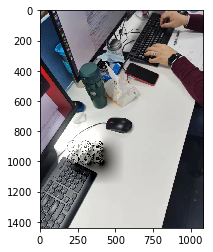

In [24]:
mask = 255 * np.ones(obj.shape, obj.dtype)

width, height, channels = im.shape
#center = (int(height/4), int(width/4))
center = (300,900)

mix_clone = cv2.seamlessClone(obj, im, mask, center, cv2.MIXED_CLONE)

imshow(mix_clone[:,:,::-1])

### Changed Method

In [45]:
import poissonimageediting as poisson

In [25]:
def t_lap_at_index_mixing(source, target, mask, index, contuor, ngb_flag):

  '''
  Function to calculate gradient with respect given index.

  input; src, tar --> one channel, same size
         index    --> omega's coordinate[i, j]
         contour  --> coutour mask(mask.shape[0], mask.shape[1])
         ngb_flag --> neigbourhood's flag at [i, j], (4,), bool


  return grad(source) with Dirichlet boundary condition


                grad_up
            o-----o-----o
            |     A     |
            |     |     |
  grad_left o<----o---->o grad_right
            |     |     |
            |     v     |
            o-----o-----o
                 grad_bottom

  '''
  
  ## current location
  i, j = index


  ## gradient for source image
  grad_right_src = float(ngb_flag[0]==True) * (source[i, j] - source[i, j+1])
  grad_left_src = float(ngb_flag[1]==True) * (source[i, j] - source[i, j-1])
  grad_bottom_src = float(ngb_flag[2]==True) * (source[i, j] - source[i+1, j])
  grad_up_src = float(ngb_flag[3]==True) * (source[i, j] - source[i-1, j])

  ## gradient for target image
  grad_right_tar = float(ngb_flag[0]==True) * (target[i, j] - target[i, j+1])
  grad_left_tar = float(ngb_flag[1]==True) * (target[i, j] - target[i, j-1])
  grad_bottom_tar = float(ngb_flag[2]==True) * (target[i, j] - target[i+1, j])
  grad_up_tar = float(ngb_flag[3]==True) * (target[i, j] - target[i-1, j])


  val = [grad_right_src, grad_left_src, grad_bottom_src, grad_up_src]

#   if(abs(grad_right_src) < abs(grad_right_tar) and mask[i, j] < 1):
#     val[0] = grad_right_tar

#   if(abs(grad_left_src) < abs(grad_left_tar) and mask[i, j] < 1):
#     val[1] = grad_left_tar

#   if(abs(grad_bottom_src) < abs(grad_bottom_tar) and mask[i, j] < 1):
#     val[2] = grad_bottom_tar

#   if(abs(grad_up_src) < abs(grad_up_tar) anmd ):
#     val[3] = grad_up_tar

  return val[0] + val[1] + val[2] + val[3]

In [39]:
src_path = './rendering_part_0/samples/rgbImg_100_2020-12-17-16-56-18.png'
mask_path = './rendering_part_0/masks4merge/mask4Merge_100_2020-12-17-16-56-18.png'
target_path = './rendering_part_0/target/IMG_4744.JPG'

In [40]:
scale = 1.2 

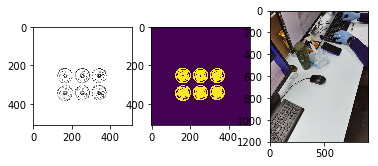

In [55]:
src = np.array(cv2.imread(src_path, 1)/255.0, dtype=np.float32)
mask = cv2.imread(mask_path, 0)
target = cv2.imread(target_path, 1)

target = np.array(target / 255.0, dtype=np.float32)
_,mask = cv2.threshold(mask, 0, 255, cv2.THRESH_OTSU)
target = cv2.resize(target, (int(target.shape[1]/scale), int(target.shape[0]/scale)))

subplot(1,3,1)
imshow(src)
subplot(1,3,2)
imshow(mask)
subplot(1,3,3)
imshow(target)
show()

In [56]:
mask = np.array(mask / 255., dtype=np.uint8)

omega, ngb_flag, yx_omega = poisson.indicies(mask)

In [236]:
N = omega.shape[0]
A = np.zeros((N,N), dtype=np.float32)
for i in range(N):
    A[i, i] = 4
    id_h, id_w = omega[i]

    ## right
    if(ngb_flag[i][0]):
        j = yx_omega[id_h][id_w+1]
        A[i, j] = -1

    ## left
    if(ngb_flag[i][1]):
        j = yx_omega[id_h][id_w-1]
        A[i, j] = -1

    ## bottom
    if(ngb_flag[i][2]):
        j = yx_omega[id_h+1][id_w]
        A[i, j] = -1

    ## up
    if(ngb_flag[i][3]):
        j = yx_omega[id_h-1][id_w]
        A[i, j] = -1

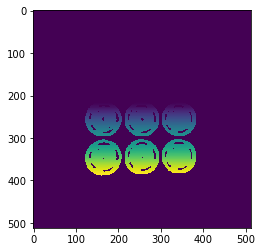

In [237]:
imshow(yx_omega)
show()

In [238]:
B = sp.lil_matrix(A)

In [239]:
u_b = np.zeros(omega.shape[0])
u_g = np.zeros(omega.shape[0])
u_r = np.zeros(omega.shape[0])

In [240]:
for index in range(omega.shape[0]):

    ## progress
    progress_bar(index, omega.shape[0]-1)

    ## apply each color channel
    u_b[index] = t_lap_at_index_mixing(src[:, :, 0], target[:, :, 0], omega[index], contour, ngb_flag[index]) \
                + constrain(target[:, :, 0], omega[index], contour, ngb_flag[index])
    u_g[index] = t_lap_at_index_mixing(src[:, :, 1], target[:, :, 1], omega[index], contour, ngb_flag[index]) \
                + constrain(target[:, :, 1], omega[index], contour, ngb_flag[index])
    u_r[index] = t_lap_at_index_mixing(src[:, :, 2], target[:, :, 2], omega[index], contour, ngb_flag[index]) \
                + constrain(target[:, :, 2], omega[index], contour, ngb_flag[index])


|##################################################|:100[%]

In [17]:
#B = sp.lil_matrix((N,N), dtype=np.float32)

In [241]:
x_b, info_b = sp.linalg.cg(B, u_b)
x_g, info_g = sp.linalg.cg(B, u_g)
x_r, info_r = sp.linalg.cg(B, u_r)

In [242]:
blended = target.copy()
overlapped = target.copy()

for index in range(omega.shape[0]):

    i, j = omega[index]

    ## normal
    blended[i][j][0] = np.clip(x_b[index], 0.0, 1.0)
    blended[i][j][1] = np.clip(x_g[index], 0.0, 1.0)
    blended[i][j][2] = np.clip(x_r[index], 0.0, 1.0)

    ## overlapping
    overlapped[i][j][0] = src[i][j][0]
    overlapped[i][j][1] = src[i][j][1]
    overlapped[i][j][2] = src[i][j][2]

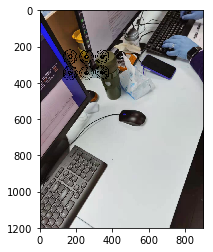

In [243]:
imshow(blended)

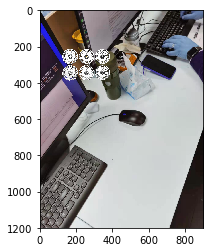

In [244]:
imshow(overlapped)

In [245]:
blended = np.array(blended*255, dtype=np.uint8)

In [246]:
overlapped = np.array(overlapped*255,dtype=np.uint8)

In [247]:
cv2.imwrite("result_t_poisson_1.jpg", blended)

True

In [130]:
cv2.imwrite("result_t_o_1.jpg", overlapped)

True

In [48]:
?cv2.imwrite

In [161]:
tmp = cv2.merge((mask,mask,mask))

In [167]:
merged_result = np.hstack((np.array(src*255, dtype=np.uint8), cv2.merge((mask, mask, mask))))#, np.array(target*255, dtype=np.uint8), overlapped, blended))

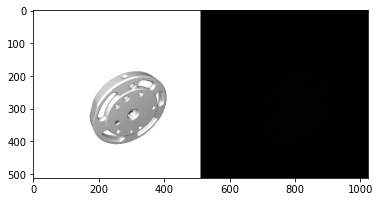

In [168]:
imshow(merged_result)

In [1]:
import matplotlib.pyplot as plt

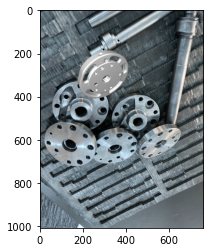

In [69]:
imshow(overlapped)

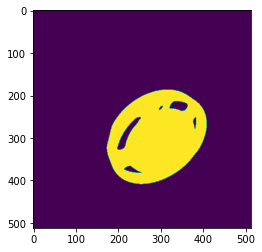

In [57]:
imshow(mask)

In [248]:
from collections import Counter

In [249]:
mask.max()

1

In [251]:
cnt = Counter(mask.flatten())

In [252]:
for id in cnt:
    print(id)

0
1


In [253]:
cnt[1]

30245

In [254]:
tmp = []

In [255]:
for id in cnt:
    if id != 0:
        tmp.append(id)

In [256]:
tmp

[1]

In [1]:
import re

In [2]:
import fnmatch

In [3]:
file_types = ['*.png']
file_types = r'|'.join([fnmatch.translate(x) for x in file_types])

In [8]:
tmp = re.match(file_types,"a.jpg")

In [9]:
tmp

In [10]:
if tmp:
    print('a')

In [11]:
import os

In [13]:
os.path.basename('./test/a.png')

'a.png'

In [15]:
re.match("re", "aa_re.jpg")